In [1]:
#_____________________
#I-AMBIENTE
#_____________________
#paquetes
#para limpieza
import numpy as np
import pandas as pd
#para matriz rala
import scipy.sparse
from scipy.sparse import csr_matrix
#para grafos
import networkx as nx
#para graficar
import matplotlib.pyplot as plt



In [2]:
#datos
df = pd.read_csv("Cooffending.csv")

In [3]:
#_____________________
#II-LIMPIEZA
#_____________________
#elimino filas duplicadas
df=df.drop_duplicates(subset =["OffenderIdentifier","CrimeIdentifier"])

In [29]:
data=df[['CrimeYear','Crimen','Criminales']]

,CrimeYear,Crimen,Criminales
0,2005,0,0
1,2008,1,1
2,2008,2,2
3,2008,3,3
4,2003,4,4
...,...,...,...
1280454,2009,1164834,539588
1280455,2009,1164632,539589
1280456,2009,1164770,539590
1280457,2009,1164835,539591


In [31]:
data=df[['Criminales','Crimen','CrimeYear']]
data = data.rename(columns = {'Criminales': 'Id', 'Crimen': 'Label','CrimeYear': 'Timestamp'}, inplace = False)

data.to_csv('data.csv')

In [5]:
#formato adecuado a las columnas de interes
for col in ['CrimeIdentifier', 'OffenderIdentifier']:
    df[col] = df[col].astype('category')
for col in ['CrimeIdentifier', 'OffenderIdentifier']:
    df[col] = df[col].astype('int64')
    
#modifico el numero de crimen y de criminal para que sean numeros consecutivos
#este paso es importante para reducir el tamaño de la matriz a justo lo que necestiamos
df['Crimen'] = pd.factorize(df['CrimeIdentifier'])[0] 
df['Criminales'] = pd.factorize(df['OffenderIdentifier'])[0] 

#convierto a np array (para hacer más rapido la matriz rala)
column=df['Crimen']
column=np.array(column)
row=df['Criminales']
row=np.array(row)
df[['Criminales','Crimen']]

,Criminales,Crimen
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
...,...,...
1280454,539588,1164834
1280455,539589,1164632
1280456,539590,1164770
1280457,539591,1164835


In [6]:
#agrego una columna de unos para indicar el match
valor=np.ones((1279987,), dtype=int)
f=np.column_stack([valor,row,column])
f

array([[      1,       0,       0],
       [      1,       1,       1],
       [      1,       2,       2],
       ...,
       [      1,  539590, 1164770],
       [      1,  539591, 1164835],
       [      1,  539592, 1164826]])

In [7]:
#_____________________
#III-Matrices
#_____________________
#datos como matriz rala
crime_matrix = csr_matrix((f[:,0], (f[:,1], f[:,2])), shape=(row.max() + 1, f[:,2].max() + 1))


In [8]:
#matriz de adjacencia
A=crime_matrix*crime_matrix.T


In [9]:
#creo objeto grafo
# ceros en la diagonal (no self loops)
A.setdiag(0)
# me quedo solo con los cruces donde hubo crimenes en comun
A.eliminate_zeros()
# creo grafo
G = nx.from_scipy_sparse_matrix(A)
# elimino los nodos sin ningun edge
G.remove_nodes_from(list(nx.isolates(G)))

In [10]:
#_____________________
#IV-JUGUEMOS
#_____________________

#datos basicos
G.number_of_nodes()#cantidad de nodos


121159

In [11]:
G.number_of_edges()#cantidad de edges


178413

In [26]:
#_____________________
#IV-CREAMOS OBJETO PARA GEPHI
#_____________________

G_2 = nx.from_scipy_sparse_matrix(A)
G_2.remove_nodes_from(list(nx.isolates(G)))

#este loop recorta todos los nodos con menos edges que el numero que determinemos
G_2_edge_list = list( G_2.edges() )
G_2_edge_weight_dict = nx.get_edge_attributes(G_2, 'weight' )
for e in G_2_edge_list:
    if G_2_edge_weight_dict[e] < 5: #aqui eliges el punto de corte (1 o 2 o 5 o 100 dependiendo el problema)
        G_2.remove_edge(e[0],e[1])
G_2.remove_nodes_from(list(nx.isolates(G_2)))
nx.write_gexf( G_2 , "red_crim.gexf" ) #crea objeto para gephi


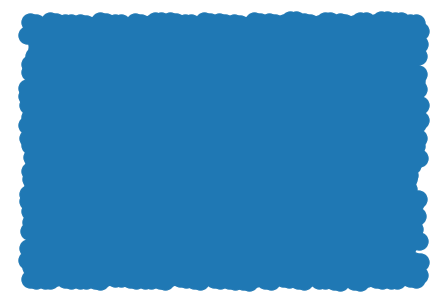

In [25]:
#red filtrando solo conexiones con pesos 5
#aqui ya vemos una estructura mejor
#analizamos solo top 10 de 1232
#repetimos pasos anteriores para tener otro objeto G diferente y no empalmar operaciones
G_2 = nx.from_scipy_sparse_matrix(A)
G_2.remove_nodes_from(list(nx.isolates(G)))

#este loop recorta todos los nodos con menos edges que el numero que determinemos
G_2_edge_list = list( G_2.edges() )
G_2_edge_weight_dict = nx.get_edge_attributes(G_2, 'weight' )
for e in G_2_edge_list:
    if G_2_edge_weight_dict[e] < 5: #aqui eliges el punto de corte (1 o 2 o 5 o 100 dependiendo el problema)
        G_2.remove_edge(e[0],e[1])
G_2.remove_nodes_from(list(nx.isolates(G_2)))
nx.draw(G_2, pos=nx.drawing.nx_agraph.graphviz_layout(G_2), with_labels=False)


In [13]:
#cantidad de connected components
nx.number_connected_components(G_2)

1232

In [14]:
nx.number_connected_components(G_2)


1232

In [16]:
#___________________________________
#ANALISIS DE LA RED GLOBAL (Y NUESTRAS 10 COMUNIDADES CON RESPECTO A LA RED GLOBAL)
#___________________________________
Gccr = sorted(nx.connected_components(G_2), key=len, reverse=True)
Gccr[0:10] #creo el np array de los nodos de los top 10 componentes (manualmente)
a=np.array([
  15463,
  168495,
  177242,
  185703,
  222034,
  238820,
  293454,
  306537,
  308844,
  312985,
  317690,
  324612,
  334620,
  341757,
  362835,
  447589,
  8929,
  10688,
  12694,
  20030,
  52037,
  64473,
  91776,
  93980,
  111982,
  119340,
  189416,
  262495,
  272398,
  273317,
  78959,
  174837,
  252394,
  271735,
  294556,
  334033,
  336864,
  339071,
  339129,
  439619,
  214679, 333760, 425543, 458162, 470072, 471157, 483701, 485287, 517707,
  241270, 250092, 307929, 308779, 329172, 379162, 412413, 436091,
  368463, 413394, 459485, 463418, 465401, 468664, 485254, 491940,
  65502, 127617, 185207, 205054, 353339, 474498, 476898,
  89836, 371161, 374771, 413493, 444352, 452984, 459069,
  214240, 227792, 274399, 291536, 301250, 341794, 357257,
  55790, 82941, 189484, 227245, 279428, 296951])

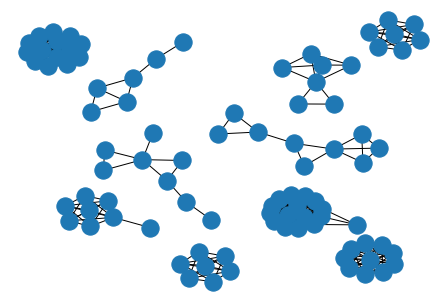

In [17]:
#GRAFICAMOS NUESTRAS TOP 10 COMUNIDADES 

G_top_10 = G.subgraph(a)
nx.draw(G_top_10, pos=nx.drawing.nx_agraph.graphviz_layout(G_top_10), with_labels=False)

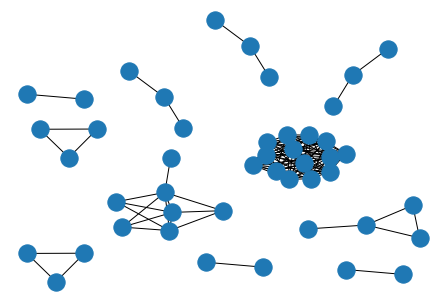

In [168]:
#GRAFICAMOS PARA UN TRESHOLD MAS PEQUEÑO, POR EJEMPLO 1
G_2 = nx.from_scipy_sparse_matrix(A)
G_2.remove_nodes_from(list(nx.isolates(G)))

#este loop recorta todos los nodos con menos edges que el numero que determinemos
G_2_edge_list = list( G_2.edges() )
G_2_edge_weight_dict = nx.get_edge_attributes(G_2, 'weight' )
for e in G_2_edge_list:
    if G_2_edge_weight_dict[e] < 1: #aqui eliges el punto de corte (1 o 2 o 5 o 100 dependiendo el problema)
        G_2.remove_edge(e[0],e[1])
G_2.remove_nodes_from(list(nx.isolates(G_2)))
G_2.number_of_nodes()
#GRAFICAMOS NUESTRAS TOP 10 COMUNIDADES ahora con un menor punto de corte
G_top_10 = G_2.subgraph(a)
nx.draw(G_top_10, pos=nx.drawing.nx_agraph.graphviz_layout(G_top_10), with_labels=False)

In [169]:
#___________________________________
#ANALISIS DE top 10 COMPONENTES (UNO POR UNO)
#___________________________________

#ELEJIMOS UN PUNTO DE CORTE DE 5


G_2 = nx.from_scipy_sparse_matrix(A)
G_2.remove_nodes_from(list(nx.isolates(G)))

#este loop recorta todos los nodos con menos edges que el numero que determinemos
G_2_edge_list = list( G_2.edges() )
G_2_edge_weight_dict = nx.get_edge_attributes(G_2, 'weight' )
for e in G_2_edge_list:
    if G_2_edge_weight_dict[e] < 5: #aqui eliges el punto de corte (1 o 2 o 5 o 100 dependiendo el problema)
        G_2.remove_edge(e[0],e[1])
G_2.remove_nodes_from(list(nx.isolates(G_2)))
G_2.number_of_nodes()


3067

In [116]:
#PRINCIPAL COMPONENTE 1
# PANDILLA ASALTA INDUSTRIA 
# ES EL COMPONENTE MAS GRANDE POR MUCHO, HAY ALGO SOSPECHOSO
#Top comoponent gr
Gccr = sorted(nx.connected_components(G_2), key=len, reverse=True)
Gr_top = G.subgraph(Gccr[0]) # Gccr es un numpy array donde cada posicion es un component


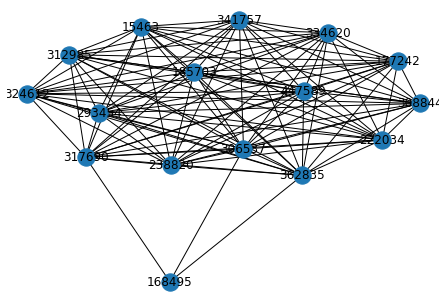

In [117]:
nx.draw(Gr_top, pos=nx.drawing.nx_agraph.graphviz_layout(Gr_top), with_labels=True)

In [79]:
a=list(Gr_top.nodes)
df_filtered = df[df['Criminales'].isin(a)]
df_filtered
# EN ESTE COMPONENTE ABUNDAN LOS DELITOS 21203 Y 21309 REFERENTES A ROBO DE MÁS DE 5000$
# SIN EMBARGO NOTAMOS UNA ESTRUCTURA FRECUENTE PUES TODOS COMETEN DELITOS ENTRE ELLOS
# NUESTRA HIPOTESIS ES QUE ES UNA PANDILLA LOCAL, HAY NODOS CENTRALES

,OffenderIdentifier,OffenderGender,CrimeIdentifier,CrimeType1,CrimeType2,CrimeType3,CrimeType4,Municipality,CrimeLocation,NumberYouthOffenders,NumberAdultOffenders,CrimeDate,CrimeYear,Crimen,Criminales
20032,23812,M,116101,21203.0,NaN,NaN,NaN,53052,4.0,0,7,12/16/2006,2006,19810,15463
20033,23812,M,839738,21203.0,21309.0,NaN,NaN,66023,4.0,0,4,10/08/2006,2006,19811,15463
20034,23812,M,60815,21309.0,NaN,NaN,NaN,54048,80.0,0,60,01/16/2006,2006,16204,15463
20035,23812,M,1402435,21203.0,NaN,NaN,NaN,59020,80.0,0,4,09/28/2006,2006,19812,15463
20036,23812,M,1614130,21203.0,NaN,NaN,NaN,37067,76.0,0,4,11/12/2006,2006,19813,15463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077081,578027,M,164924,21702.0,NaN,NaN,NaN,49058,4.0,0,3,04/28/2007,2007,700144,447589
1077082,578027,M,27486,21203.0,21309.0,NaN,NaN,66023,4.0,0,8,07/13/2007,2007,19824,447589
1077083,578027,M,27197,21203.0,21309.0,NaN,NaN,66023,4.0,0,6,04/29/2007,2007,370962,447589
1077084,578027,M,1403673,21203.0,NaN,NaN,NaN,59020,80.0,0,5,05/13/2007,2007,19825,447589


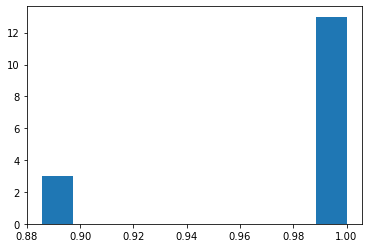

In [21]:
#h=nx.eigenvector_centrality(Gr_top)
#h=nx.betweenness_centrality(Gr_top)
h=nx.clustering(Gr_top)
data = list(h.items())
H=np.array(data)
plt.hist(H[:,1])
plt.show()

In [80]:
df_filtered['CrimeType1'].value_counts()

#INTRO EF. ETA. COM. PUBL. 2 es la moda
# MEFAIT DOMMAGE 5000$ OU (daño hecho)
#AUTRES VOLS + 5000$ (asalto/robo)

21203.0    218
21702.0     43
21309.0     20
3410.0      17
21352.0     16
21409.0     13
2150.0      12
21401.0      9
3520.0       9
1640.0       7
21201.0      6
1430.0       6
16102.0      5
3420.0       4
21607.0      4
8100.0       3
1625.0       3
21699.0      2
4220.0       2
4240.0       2
21351.0      2
7600.0       2
21209.0      2
21101.0      1
92401.0      1
3470.0       1
21602.0      1
37301.0      1
4140.0       1
16103.0      1
9320.0       1
21603.0      1
1420.0       1
4120.0       1
14601.0      1
92309.0      1
9311.0       1
91303.0      1
Name: CrimeType1, dtype: int64

In [90]:
#GEOGRAFÍA 
df_filtered['Municipality'].value_counts()
#LA MAYORÍA DE LOS DELITOS SE CONCENTRARON EN UNA MUNICIPALIDAD 54048


54048    81
66023    33
57020    24
49058    23
43027    22
59020    22
53052    21
65005    15
56083    13
23027    12
37067    11
58227    11
47017    10
93042     8
12080     8
89008     8
54065     7
66087     6
57040     6
54008     5
67050     5
23025     4
71065     4
74005     4
13080     4
49048     4
46112     4
46080     4
12072     3
26030     3
57005     3
55008     3
67040     3
55015     2
25213     2
78005     2
34017     2
49057     2
54090     2
70052     2
54025     1
67010     1
57045     1
54060     1
53032     1
49105     1
54072     1
54100     1
54105     1
42098     1
61025     1
47015     1
49025     1
53010     1
Name: Municipality, dtype: int64

In [91]:
#LA MAYORIA SE CONCENTRO EN COMERCIO O INDUSTRIA (4, 76 Y 80)
df_filtered['CrimeLocation'].value_counts()

4.0     94
76.0    91
80.0    64
9.0     24
55.0    23
1.0     22
2.0     13
5.0     11
70.0    10
72.0     7
19.0     7
58.0     7
99.0     5
52.0     5
7.0      5
71.0     4
77.0     3
29.0     3
60.0     2
62.0     2
38.0     2
16.0     2
74.0     1
Name: CrimeLocation, dtype: int64

In [92]:
#TODOS HOMBRES
df_filtered['OffenderGender'].value_counts()

M    422
Name: OffenderGender, dtype: int64

In [93]:
#TODOS ADULTOS Y UN JOVEN
df_filtered['NumberYouthOffenders'].value_counts()

0    421
1      1
Name: NumberYouthOffenders, dtype: int64

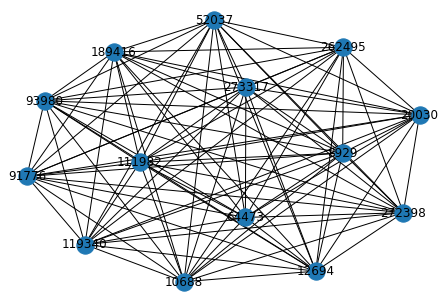

In [79]:
#PRINCIPAL COMPONENTE 2
# BANDA EXTORSIONADORA
# NUESTRA HIPOTESIS ES QUE EVIDENTEMENTE ES UNA RED CRIMINAL
# AQUI SI PODRIAMOS INTENTAR ENCONTRAR LA MENTE DETRAS DE TODO
#Top comoponent gr
Gccr = sorted(nx.connected_components(G_2), key=len, reverse=True)
Gr_top = G.subgraph(Gccr[1])

# graficamos red para nuestra grafica filtrada por peso
nx.draw(Gr_top, pos=nx.drawing.nx_agraph.graphviz_layout(Gr_top), with_labels=True)

In [80]:
a=list(Gr_top.nodes)
df_filtered = df[df['Criminales'].isin(a)]
df_filtered

,OffenderIdentifier,OffenderGender,CrimeIdentifier,CrimeType1,CrimeType2,CrimeType3,CrimeType4,Municipality,CrimeLocation,NumberYouthOffenders,NumberAdultOffenders,CrimeDate,CrimeYear,Crimen,Criminales
10773,13424,M,423071,16201.0,3830.0,32301.0,NaN,66023,60.0,0,14,05/01/2003,2003,10653,8929
10774,13424,M,423094,16201.0,3830.0,32301.0,NaN,66023,60.0,0,14,02/28/2003,2003,10654,8929
10775,13424,M,402794,16201.0,3830.0,32301.0,NaN,66023,0.0,0,14,06/18/2003,2003,10655,8929
10776,13424,M,12010,16201.0,3830.0,32301.0,NaN,66023,55.0,0,13,06/18/2003,2003,10656,8929
10777,13424,M,423069,16201.0,3830.0,32301.0,NaN,66023,60.0,0,14,04/03/2003,2003,10657,8929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612902,371672,M,423074,16201.0,3830.0,32301.0,NaN,66023,60.0,0,13,06/02/2003,2003,10661,273317
612903,371672,M,423090,16201.0,3830.0,32301.0,NaN,66023,60.0,0,14,06/25/2003,2003,10662,273317
612904,371672,M,423073,16201.0,3830.0,32301.0,NaN,66023,60.0,0,14,06/18/2003,2003,10663,273317
612905,371672,M,423070,16201.0,3830.0,32301.0,NaN,66023,60.0,0,14,06/18/2003,2003,10664,273317


In [81]:
df_filtered['CrimeType1'].value_counts()
#DEFINITIVAMENTE ES UN GRUPO DE EXTORCIONADORES

16201.0    179
3375.0       3
92309.0      2
1430.0       2
3520.0       2
42301.0      1
8100.0       1
3410.0       1
Name: CrimeType1, dtype: int64

In [82]:
#GEOGRAFÍA 
df_filtered['Municipality'].value_counts()
#LA MAYORÍA DE LOS DELITOS SE CONCENTRARON EN UNA MUNICIPALIDAD 66023


66023    186
60013      2
65005      1
56010      1
58227      1
Name: Municipality, dtype: int64

In [83]:
#LA MAYORIA SE CONCENTRO EN SALLE DE JEUX 
df_filtered['CrimeLocation'].value_counts()

60.0    125
1.0      15
0.0      15
19.0     13
55.0     13
9.0       4
2.0       2
3.0       1
8.0       1
51.0      1
21.0      1
Name: CrimeLocation, dtype: int64

In [84]:
#TODOS HOMBRES
df_filtered['OffenderGender'].value_counts()

M    191
Name: OffenderGender, dtype: int64

In [85]:
#TODOS ADULTOS
df_filtered['NumberYouthOffenders'].value_counts()

0    191
Name: NumberYouthOffenders, dtype: int64

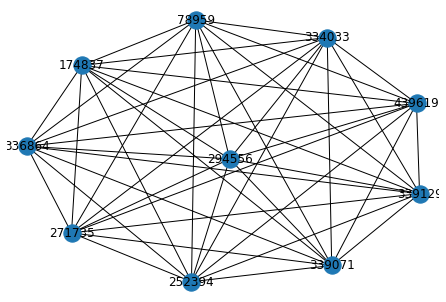

In [94]:
#PRINCIPAL COMPONENTE 3
# BANDA ROBACOHCES
# NUESTRA HIPOTESIS ES QUE EVIDENTEMENTE ES UNA RED CRIMINAL
# AQUI SI PODRIAMOS INTENTAR ENCONTRAR LA MENTE DETRAS DE TODO
# AQUI ES MUY EVIDENTE PORQUE SON MUY POQUITAS PERSONAS 
# ABARCAN MUCHOS MUNICIPIOS, TAL VEZ OPERAN EN CARRETERA
# HAY UN NODO CENTRAL
#Top comoponent gr
Gccr = sorted(nx.connected_components(G_2), key=len, reverse=True)
Gr_top = G.subgraph(Gccr[2])

# graficamos red para nuestra grafica filtrada por peso
nx.draw(Gr_top, pos=nx.drawing.nx_agraph.graphviz_layout(Gr_top), with_labels=True)

In [95]:
a=list(Gr_top.nodes)
df_filtered = df[df['Criminales'].isin(a)]
df_filtered

,OffenderIdentifier,OffenderGender,CrimeIdentifier,CrimeType1,CrimeType2,CrimeType3,CrimeType4,Municipality,CrimeLocation,NumberYouthOffenders,NumberAdultOffenders,CrimeDate,CrimeYear,Crimen,Criminales
131031,115830,M,876163,38403.0,NaN,NaN,NaN,66023,72.0,0,43,02/07/2006,2006,41641,78959
131032,115830,M,1403474,2150.0,NaN,NaN,NaN,59015,9.0,0,1,04/06/2007,2007,128858,78959
131033,115830,M,1555703,21309.0,NaN,NaN,NaN,45075,2.0,0,3,08/21/2007,2007,128859,78959
131034,115830,M,993806,21352.0,NaN,NaN,NaN,81017,0.0,0,2,06/07/2007,2007,128860,78959
131035,115830,M,720913,2150.0,NaN,NaN,NaN,58227,17.0,0,1,01/11/2007,2007,128861,78959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057233,569918,M,1555619,21352.0,NaN,NaN,NaN,45065,5.0,0,2,07/31/2007,2007,538149,439619
1057234,569918,M,1555538,21309.0,NaN,NaN,NaN,45075,40.0,0,2,07/13/2007,2007,538154,439619
1057235,569918,M,750216,21309.0,NaN,NaN,NaN,32013,40.0,0,2,07/04/2007,2007,538158,439619
1057236,569918,M,750218,21309.0,NaN,NaN,NaN,32013,40.0,0,2,07/06/2007,2007,538187,439619


In [96]:
df_filtered['CrimeType1'].value_counts()
#ROBO DE CAMION, ROBO DE MAS DE 5000$ ROBO DE AUTOMOBIL, ROBO DE TRACTOR, ROBO DE OTRO VEHICULO

21352.0    110
21309.0     67
21351.0     17
21355.0     13
21359.0     12
38403.0     10
2150.0       9
21409.0      8
21354.0      7
3410.0       6
3520.0       5
21353.0      3
92309.0      2
21201.0      2
3890.0       2
21357.0      2
21203.0      2
3780.0       2
8100.0       2
1430.0       2
4140.0       1
21401.0      1
5330.0       1
42301.0      1
9330.0       1
21603.0      1
1340.0       1
21202.0      1
75001.0      1
21704.0      1
4120.0       1
91202.0      1
1640.0       1
21405.0      1
37109.0      1
Name: CrimeType1, dtype: int64

In [97]:
#GEOGRAFÍA 
df_filtered['Municipality'].value_counts()
#10 PERSONAS EN 69 LOCALIDADES
# DEFINITIVAMENTE OPERAN EN CARRETERA


43027    81
23027    15
45075    14
66023    14
49058    11
         ..
39085     1
41117     1
57035     1
59015     1
45060     1
Name: Municipality, Length: 69, dtype: int64

In [98]:
#LA MAYORIA SE CONCENTRO EN ESTACIONAMIENTOS, HOGARES Y LA VIA PÚBLICA
df_filtered['CrimeLocation'].value_counts()

5.0     98
1.0     65
9.0     26
4.0     13
72.0    12
76.0    12
40.0    11
2.0      9
39.0     7
55.0     6
10.0     5
3.0      4
0.0      4
58.0     3
11.0     3
7.0      3
29.0     2
81.0     2
17.0     2
78.0     2
74.0     2
30.0     1
70.0     1
38.0     1
52.0     1
90.0     1
Name: CrimeLocation, dtype: int64

In [99]:
#TODOS HOMBRES
df_filtered['OffenderGender'].value_counts()

M    298
Name: OffenderGender, dtype: int64

In [100]:
#TODOS ADULTOS
df_filtered['NumberYouthOffenders'].value_counts()

0    298
Name: NumberYouthOffenders, dtype: int64

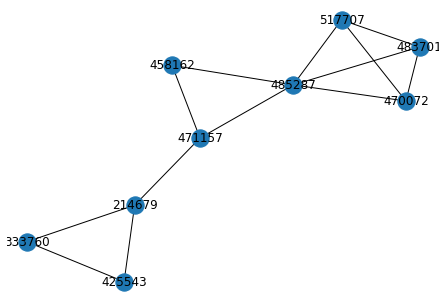

In [102]:
#PRINCIPAL COMPONENTE 4
# ESTE GRUPO ES UN ENIGMA
#SOSPECHO QUE SOLO ES GENTE MALA CON UNIONES DE COINCIDENCIA
# TAL VEZ UN GRUPO EN SITUACION DE VULNERABILIDAD, COMO MIGRANTES
# ESTA GRAFICA ES IDEAL PARA EVALUAR BETWEENES CENTRALITY
# HAY MUJERES Y JOVENES LOS DELITOS SON DIVERSOS Y SE CONCENTRAN EN UN MUNCIPIO
# TAL VEZ ES UN GRUPO DE MIGRANTES VULNERABLES
#Top comoponent gr
Gccr = sorted(nx.connected_components(G_2), key=len, reverse=True)
Gr_top = G.subgraph(Gccr[3])

# graficamos red para nuestra grafica filtrada por peso
nx.draw(Gr_top, pos=nx.drawing.nx_agraph.graphviz_layout(Gr_top), with_labels=True)

In [103]:
a=list(Gr_top.nodes)
df_filtered = df[df['Criminales'].isin(a)]
df_filtered

,OffenderIdentifier,OffenderGender,CrimeIdentifier,CrimeType1,CrimeType2,CrimeType3,CrimeType4,Municipality,CrimeLocation,NumberYouthOffenders,NumberAdultOffenders,CrimeDate,CrimeYear,Crimen,Criminales
455581,295671,M,381816,21201.0,NaN,NaN,NaN,76020,2.0,0,1,04/14/2003,2003,442240,214679
455582,295671,M,383325,1640.0,NaN,NaN,NaN,76020,1.0,0,1,10/13/2004,2004,442241,214679
455583,295671,M,382722,3520.0,NaN,NaN,NaN,76020,2.0,0,1,03/04/2004,2004,442242,214679
455584,295671,M,383384,21201.0,2150.0,NaN,NaN,76020,2.0,0,2,10/31/2004,2004,360106,214679
455585,295671,M,382721,21409.0,NaN,NaN,NaN,76020,2.0,0,1,03/04/2004,2004,442243,214679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245065,648632,M,244475,21601.0,21409.0,NaN,NaN,79088,5.0,0,4,03/31/2008,2008,1054078,517707
1245066,648632,M,244482,21601.0,NaN,NaN,NaN,79088,76.0,0,4,03/31/2008,2008,1054079,517707
1245067,648632,M,244480,21601.0,21409.0,NaN,NaN,79088,72.0,0,4,03/31/2008,2008,1054080,517707
1245068,648632,M,244477,21601.0,NaN,NaN,NaN,79088,55.0,0,4,03/31/2008,2008,1054081,517707


In [104]:
df_filtered['CrimeType1'].value_counts()
#ROBO EN VEHICULO
#INTRO EF. ETA. COM. PUBL. 
#FRAUDE DE TARJETA DE CREDIO
#ROBO AUTMOTRIZ


21401.0    50
21203.0    43
21601.0    30
21351.0    14
21409.0    13
3410.0     12
21201.0    10
3520.0      8
21352.0     7
4140.0      6
21405.0     5
2150.0      4
16102.0     3
21202.0     3
21704.0     3
91302.0     2
91303.0     2
1640.0      2
1330.0      2
21357.0     2
21607.0     2
21101.0     1
21109.0     1
21603.0     1
92301.0     1
21699.0     1
21301.0     1
8100.0      1
21702.0     1
21604.0     1
4220.0      1
7600.0      1
21209.0     1
39999.0     1
Name: CrimeType1, dtype: int64

In [105]:
df_filtered['Municipality'].value_counts()
#PROBABLEMENTE OPERAN EN LA LOCALIDAD 127


76020    127
79088     30
80130     12
78070      9
76043      8
76008      5
74005      5
66023      4
79078      4
75017      4
76055      4
60013      3
23027      3
61025      3
39062      2
47015      2
89008      2
81017      1
62080      1
48038      1
62037      1
43027      1
45070      1
37067      1
77022      1
76025      1
Name: Municipality, dtype: int64

In [106]:
df_filtered['CrimeLocation'].value_counts()
#OPERAN EN ESTACIONAMIENTOS, VIA PÚBLICA Y HOGARES

5.0     39
1.0     33
9.0     26
13.0    21
76.0    15
70.0    11
2.0     10
55.0    10
72.0    10
4.0      6
38.0     6
7.0      6
71.0     5
58.0     5
61.0     5
28.0     4
39.0     4
40.0     3
0.0      3
21.0     2
3.0      2
16.0     2
19.0     2
41.0     1
18.0     1
10.0     1
Name: CrimeLocation, dtype: int64

In [107]:
#ESTE GRUPO ES MAS DIVERSO
df_filtered['OffenderGender'].value_counts()

M    223
F     13
Name: OffenderGender, dtype: int64

In [108]:
#ESTE GRUPO ES MAS DIVERSO
df_filtered['NumberYouthOffenders'].value_counts()

0    234
1      2
Name: NumberYouthOffenders, dtype: int64

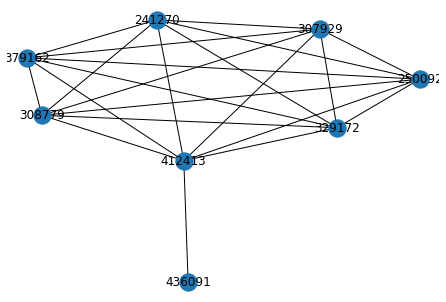

In [129]:
#PRINCIPAL COMPONENTE 5

#MUCHAS MUJERES
#TAMBIEN ES UN ENIGMA
#DELITOS SON ROBOS MENORES EN SUPER MERCADOS

#Top comoponent gr
Gccr = sorted(nx.connected_components(G_2), key=len, reverse=True)
Gr_top = G.subgraph(Gccr[4])

# graficamos red para nuestra grafica filtrada por peso
nx.draw(Gr_top, pos=nx.drawing.nx_agraph.graphviz_layout(Gr_top), with_labels=True)

In [131]:
a=list(Gr_top.nodes)
df_filtered = df[df['Criminales'].isin(a)]
df_filtered

,OffenderIdentifier,OffenderGender,CrimeIdentifier,CrimeType1,CrimeType2,CrimeType3,CrimeType4,Municipality,CrimeLocation,NumberYouthOffenders,NumberAdultOffenders,CrimeDate,CrimeYear,Crimen,Criminales
527643,330247,F,173720,21405.0,NaN,NaN,NaN,30030,70.0,0,4,12/15/2005,2005,510293,241270
527644,330247,F,173721,21201.0,NaN,NaN,NaN,30025,1.0,0,4,12/15/2005,2005,510294,241270
527645,330247,F,173724,21201.0,NaN,NaN,NaN,30030,1.0,0,4,12/15/2005,2005,510295,241270
527646,330247,F,634036,21309.0,NaN,NaN,NaN,12057,70.0,0,6,07/20/2006,2006,510296,241270
527647,330247,F,706930,21409.0,NaN,NaN,NaN,10005,70.0,0,7,07/20/2006,2006,510297,241270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048196,566341,F,32682,21203.0,NaN,NaN,NaN,66023,4.0,0,2,11/20/2008,2008,927080,436091
1048197,566341,F,507929,3830.0,21409.0,NaN,NaN,66023,71.0,0,1,06/12/2009,2009,981438,436091
1048198,566341,F,141222,21405.0,NaN,NaN,NaN,66023,71.0,0,4,05/13/2009,2009,981439,436091
1048199,566341,F,141227,21409.0,NaN,NaN,NaN,66023,4.0,0,4,05/13/2009,2009,981440,436091


In [134]:
df_filtered['CrimeType1'].value_counts()


21409.0    31
21309.0    18
21203.0    11
21201.0     8
21405.0     8
21305.0     4
3410.0      1
2150.0      1
16102.0     1
3830.0      1
8100.0      1
3520.0      1
Name: CrimeType1, dtype: int64

In [135]:
df_filtered['CrimeLocation'].value_counts()
#EL LUGAR PREFERIDO ES LA TIENDA DE CONVENIENCIA


70.0    39
4.0     15
71.0    15
1.0      6
93.0     2
21.0     2
76.0     2
2.0      2
28.0     1
3.0      1
94.0     1
Name: CrimeLocation, dtype: int64

In [136]:
df_filtered['Municipality'].value_counts()
#SE CENTRAN EN 66023


66023    17
18045     8
13055     7
13060     7
10005     7
17078     7
30030     6
12057     6
33102     5
33095     4
30025     3
15904     2
35050     2
34048     2
66087     1
75017     1
77043     1
Name: Municipality, dtype: int64

In [132]:
#ESTE GRUPO ES MAS DIVERSO
df_filtered['OffenderGender'].value_counts()


F    47
M    39
Name: OffenderGender, dtype: int64

In [133]:
# SON SEÑORAS GRANDES
df_filtered['NumberYouthOffenders'].value_counts()

0    86
Name: NumberYouthOffenders, dtype: int64

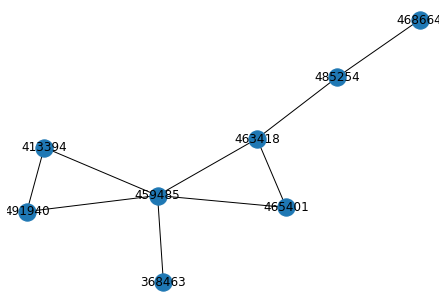

In [145]:
#PRINCIPAL COMPONENTE  6
# PANDILLA ASALTA INDUSTRIA 
# ES EL COMPONENTE MAS GRANDE POR MUCHO, HAY ALGO SOSPECHOSO
#Top comoponent gr
Gccr = sorted(nx.connected_components(G_2), key=len, reverse=True)
Gr_top = G.subgraph(Gccr[5])

# graficamos red para nuestra grafica filtrada por peso
nx.draw(Gr_top, pos=nx.drawing.nx_agraph.graphviz_layout(Gr_top), with_labels=True)

In [146]:
a=list(Gr_top.nodes)
df_filtered = df[df['Criminales'].isin(a)]
df_filtered

,OffenderIdentifier,OffenderGender,CrimeIdentifier,CrimeType1,CrimeType2,CrimeType3,CrimeType4,Municipality,CrimeLocation,NumberYouthOffenders,NumberAdultOffenders,CrimeDate,CrimeYear,Crimen,Criminales
868208,494347,M,1302027,1420.0,NaN,NaN,NaN,23027,NaN,0,1,08/23/2006,2006,824056,368463
868209,494347,M,1318308,21603.0,NaN,NaN,NaN,23027,NaN,0,1,11/13/2007,2007,824057,368463
868210,494347,M,1327172,21353.0,NaN,NaN,NaN,23027,NaN,0,1,09/09/2008,2008,824058,368463
868211,494347,M,1623241,3410.0,NaN,NaN,NaN,37067,3.0,0,1,03/22/2009,2009,824059,368463
868212,494347,M,1623244,21352.0,NaN,NaN,NaN,37067,39.0,0,2,03/23/2009,2009,824060,368463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188238,622784,M,1430507,21605.0,NaN,NaN,NaN,94068,37.0,0,2,01/20/2008,2008,1089087,491940
1188239,622784,M,569443,21202.0,NaN,NaN,NaN,91030,40.0,0,3,11/12/2008,2008,929451,491940
1188240,622784,M,569420,21202.0,NaN,NaN,NaN,91030,40.0,0,3,11/12/2008,2008,929454,491940
1188241,622784,M,569413,21351.0,NaN,NaN,NaN,91025,1.0,0,3,11/11/2008,2008,929455,491940


In [147]:
df_filtered['CrimeType1'].value_counts()
#ROBO DE AUTOMOBIL
#INFRACTION CAUTIONNEMENT (VIOLACION DE RESTRICCION PENAL)   
# ES GENTE REINCIDENTE
#BRIS D''ORDONNANCE    NO LE HIZO CASO AL JUEZ


21351.0    50
3410.0     28
3520.0     28
21201.0    17
21202.0    13
21357.0    12
21203.0    10
2150.0      9
21102.0     7
21401.0     7
21352.0     6
4140.0      6
1640.0      6
21409.0     4
21405.0     3
1430.0      3
21353.0     3
3440.0      3
21603.0     3
4130.0      2
6450.0      2
21209.0     2
21356.0     2
21702.0     2
1420.0      2
1625.0      1
16101.0     1
21406.0     1
21605.0     1
91302.0     1
21601.0     1
52101.0     1
3420.0      1
8100.0      1
3780.0      1
14601.0     1
3480.0      1
Name: CrimeType1, dtype: int64

In [148]:
df_filtered['CrimeLocation'].value_counts()
#OPERAN EN HOGARES


1.0     68
5.0     31
40.0    25
2.0     18
72.0    13
7.0     11
16.0    10
9.0      9
4.0      9
39.0     6
76.0     6
10.0     5
58.0     4
38.0     2
8.0      2
55.0     2
19.0     2
36.0     2
70.0     2
99.0     2
41.0     1
37.0     1
71.0     1
23.0     1
74.0     1
3.0      1
Name: CrimeLocation, dtype: int64

In [149]:
df_filtered['Municipality'].value_counts()
#ALGUNOS MUCNIPIOS (MUCHOS PARA SER TAN POCAS PERSONAS)


91025    80
94068    49
91035    29
91030    20
91042    17
37067    16
23027     8
91020     8
93042     3
93065     2
92045     2
93070     2
52007     2
93055     1
92022     1
27065     1
52035     1
Name: Municipality, dtype: int64

In [150]:
#2 MUJERES
df_filtered['OffenderGender'].value_counts()


M    240
F      2
Name: OffenderGender, dtype: int64

In [151]:
# ALGUNOS JOVENES
df_filtered['NumberYouthOffenders'].value_counts()

0    234
1      8
Name: NumberYouthOffenders, dtype: int64

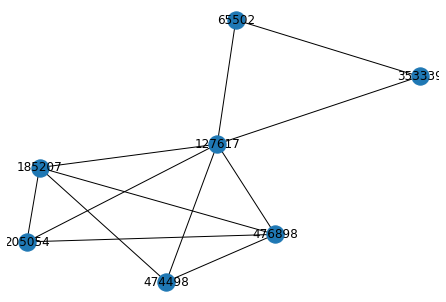

In [152]:
#PRINCIPAL COMPONENTE  7
#TODO UN MISTERIOS
#PARECE ALGO MUY PARTICULAR
#Top comoponent gr
Gccr = sorted(nx.connected_components(G_2), key=len, reverse=True)
Gr_top = G.subgraph(Gccr[6])

# graficamos red para nuestra grafica filtrada por peso
nx.draw(Gr_top, pos=nx.drawing.nx_agraph.graphviz_layout(Gr_top), with_labels=True)

In [153]:
a=list(Gr_top.nodes)
df_filtered = df[df['Criminales'].isin(a)]
df_filtered

,OffenderIdentifier,OffenderGender,CrimeIdentifier,CrimeType1,CrimeType2,CrimeType3,CrimeType4,Municipality,CrimeLocation,NumberYouthOffenders,NumberAdultOffenders,CrimeDate,CrimeYear,Crimen,Criminales
103863,97047,F,968473,21405.0,NaN,NaN,NaN,81017,NaN,0,3,12/16/2003,2003,102200,65502
103864,97047,F,968474,21405.0,NaN,NaN,NaN,81017,NaN,0,3,12/16/2003,2003,102201,65502
103865,97047,F,968468,21405.0,NaN,NaN,NaN,81017,NaN,0,3,12/16/2003,2003,102202,65502
103866,97047,F,968467,21405.0,NaN,NaN,NaN,81017,NaN,0,3,12/16/2003,2003,102203,65502
103867,97047,F,968469,21405.0,NaN,NaN,NaN,81017,NaN,0,3,12/16/2003,2003,102204,65502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150772,607651,M,993542,21357.0,NaN,NaN,NaN,81017,NaN,0,1,05/28/2007,2007,1068012,476898
1150773,607651,M,991185,21201.0,NaN,NaN,NaN,81017,NaN,0,1,02/20/2007,2007,1068013,476898
1150774,607651,M,997419,21352.0,NaN,NaN,NaN,81017,NaN,0,1,11/06/2007,2007,1068014,476898
1150775,607651,M,1212235,3410.0,NaN,NaN,NaN,82035,19.0,0,1,03/20/2008,2008,1068015,476898


In [154]:
df_filtered['CrimeType1'].value_counts()


21405.0    32
21201.0    26
21357.0    15
21209.0    14
2150.0     11
21409.0     7
21202.0     6
3410.0      6
3520.0      3
21353.0     2
4140.0      2
21352.0     2
21602.0     2
21699.0     2
3480.0      1
1640.0      1
42303.0     1
3470.0      1
4220.0      1
21309.0     1
8100.0      1
1430.0      1
Name: CrimeType1, dtype: int64

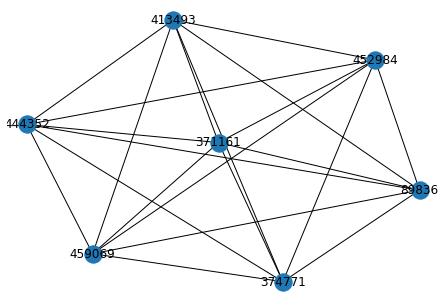

In [158]:
#PRINCIPAL COMPONENTE  8
#ESTE ESTA CREEPY
#SON HOMBRES Y MUJERES QUE HAN CONSPIRADO PARA ASESINAR A ALGUIEN
#HAY UNA MENTE MAESTRA EVIDENTE
#Top comoponent gr
Gccr = sorted(nx.connected_components(G_2), key=len, reverse=True)
Gr_top = G.subgraph(Gccr[7])

# graficamos red para nuestra grafica filtrada por peso
nx.draw(Gr_top, pos=nx.drawing.nx_agraph.graphviz_layout(Gr_top), with_labels=True)

In [156]:
a=list(Gr_top.nodes)
df_filtered = df[df['Criminales'].isin(a)]
df_filtered

,OffenderIdentifier,OffenderGender,CrimeIdentifier,CrimeType1,CrimeType2,CrimeType3,CrimeType4,Municipality,CrimeLocation,NumberYouthOffenders,NumberAdultOffenders,CrimeDate,CrimeYear,Crimen,Criminales
153398,130746,M,318822,1430.0,21699.0,21702.0,NaN,63035,4.0,0,1,11/24/2003,2003,150717,89836
153399,130746,M,318774,1640.0,NaN,NaN,NaN,51015,1.0,0,1,05/08/2004,2004,150718,89836
153400,130746,M,318648,1430.0,NaN,NaN,NaN,51015,40.0,0,1,02/01/2004,2004,150719,89836
153401,130746,M,318915,1330.0,1430.0,NaN,NaN,51015,1.0,0,1,07/29/2004,2004,150720,89836
153402,130746,M,240762,3520.0,NaN,NaN,NaN,79025,1.0,0,1,12/27/2004,2004,150721,89836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105796,589646,F,319810,21351.0,NaN,NaN,NaN,51015,5.0,0,6,01/03/2006,2006,829880,459069
1105797,589646,F,307823,21351.0,NaN,NaN,NaN,52035,71.0,0,6,01/04/2006,2006,829881,459069
1105798,589646,F,1610752,3830.0,3440.0,NaN,NaN,37067,7.0,0,7,01/05/2006,2006,150725,459069
1105799,589646,F,1610751,21101.0,NaN,NaN,NaN,37067,76.0,0,7,01/05/2006,2006,150726,459069


In [159]:
df_filtered['CrimeType1'].value_counts()
#ROBO AUTOMOBIL
#CONSPIRACION
#INCENDIO DE INMUEBLE
# CONSPIRACION DE ASESINATO

21351.0    23
3830.0     15
3410.0      8
21101.0     7
1220.0      5
1420.0      4
4140.0      3
1640.0      3
1625.0      2
42401.0     2
3520.0      2
1330.0      2
1430.0      2
2150.0      1
21405.0     1
Name: CrimeType1, dtype: int64

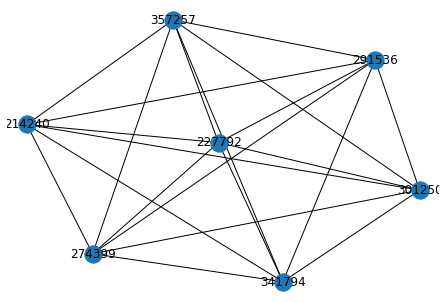

In [160]:
#PRINCIPAL COMPONENTE  9
#ESTE ES DE MARIHUANA
Gccr = sorted(nx.connected_components(G_2), key=len, reverse=True)
Gr_top = G.subgraph(Gccr[8])

# graficamos red para nuestra grafica filtrada por peso
nx.draw(Gr_top, pos=nx.drawing.nx_agraph.graphviz_layout(Gr_top), with_labels=True)

In [161]:
a=list(Gr_top.nodes)
df_filtered = df[df['Criminales'].isin(a)]
df_filtered

,OffenderIdentifier,OffenderGender,CrimeIdentifier,CrimeType1,CrimeType2,CrimeType3,CrimeType4,Municipality,CrimeLocation,NumberYouthOffenders,NumberAdultOffenders,CrimeDate,CrimeYear,Crimen,Criminales
454411,295132,M,212285,4240.0,44402.0,NaN,NaN,37067,19.0,0,57,10/27/2005,2005,17375,214240
454412,295132,M,749807,44402.0,NaN,NaN,NaN,32058,10.0,0,3,09/18/2006,2006,441141,214240
454413,295132,M,749790,44402.0,NaN,NaN,NaN,39085,10.0,0,7,09/15/2006,2006,441142,214240
454414,295132,M,749787,44402.0,NaN,NaN,NaN,32085,10.0,0,6,09/13/2006,2006,441143,214240
454415,295132,M,749783,44402.0,NaN,NaN,NaN,33070,10.0,0,6,09/13/2006,2006,441144,214240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837401,480730,M,749793,44402.0,NaN,NaN,NaN,49075,10.0,0,7,09/15/2006,2006,441145,357257
837402,480730,M,749784,44402.0,NaN,NaN,NaN,32085,10.0,0,7,09/13/2006,2006,441146,357257
837403,480730,M,749791,44402.0,NaN,NaN,NaN,39010,10.0,0,7,09/15/2006,2006,441147,357257
837404,480730,M,749792,44402.0,NaN,NaN,NaN,39117,10.0,0,7,09/15/2006,2006,441148,357257


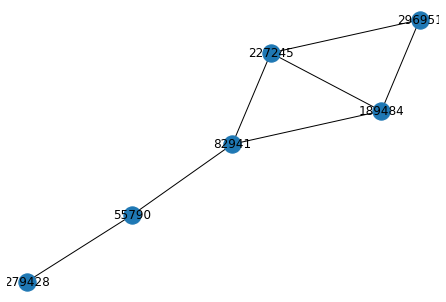

In [162]:
#PRINCIPAL COMPONENTE  10
#RED DE ESTAFADORES DE TARJETA DE CREDITO PEQUEÑA PERO REINCIDENTE
Gccr = sorted(nx.connected_components(G_2), key=len, reverse=True)
Gr_top = G.subgraph(Gccr[9])

# graficamos red para nuestra grafica filtrada por peso
nx.draw(Gr_top, pos=nx.drawing.nx_agraph.graphviz_layout(Gr_top), with_labels=True)

In [163]:
a=list(Gr_top.nodes)
df_filtered = df[df['Criminales'].isin(a)]
df_filtered

,OffenderIdentifier,OffenderGender,CrimeIdentifier,CrimeType1,CrimeType2,CrimeType3,CrimeType4,Municipality,CrimeLocation,NumberYouthOffenders,NumberAdultOffenders,CrimeDate,CrimeYear,Crimen,Criminales
85696,83474,M,1551526,21401.0,NaN,NaN,NaN,45030,5.0,0,2,12/28/2003,2003,84411,55790
85697,83474,M,1551521,21601.0,2150.0,NaN,NaN,45070,61.0,0,4,12/27/2003,2003,84412,55790
85698,83474,M,1551522,21601.0,NaN,NaN,NaN,45070,61.0,0,3,12/27/2003,2003,84413,55790
85699,83474,M,1551527,21401.0,NaN,NaN,NaN,45030,5.0,0,2,12/27/2003,2003,84414,55790
85700,83474,M,1454080,3520.0,NaN,NaN,NaN,43027,5.0,0,1,07/16/2005,2005,84415,55790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676124,402476,F,1602278,21601.0,NaN,NaN,NaN,37067,61.0,0,3,10/22/2003,2003,379914,296951
676125,402476,F,1602283,21401.0,NaN,NaN,NaN,51090,9.0,0,3,10/22/2003,2003,379921,296951
676126,402476,F,1602279,21401.0,NaN,NaN,NaN,37067,5.0,0,3,10/22/2003,2003,379924,296951
676127,402476,F,1602276,21401.0,NaN,NaN,NaN,37067,4.0,0,3,10/22/2003,2003,379925,296951


In [164]:
df_filtered['CrimeType1'].value_counts()


21601.0    51
21401.0    48
21409.0     4
3410.0      3
1430.0      3
21699.0     1
21351.0     1
42301.0     1
3530.0      1
16201.0     1
21704.0     1
4140.0      1
3520.0      1
Name: CrimeType1, dtype: int64

In [36]:
#______________________________________

# ANALISIS CON COMPONENTES CON EDGES MAS PESADOS (50)
#______________________________________

#red filtrando solo conexiones con pesos 25
G_2 = nx.from_scipy_sparse_matrix(A)
G_2.remove_nodes_from(list(nx.isolates(G)))

#este loop recorta todos los nodos con menos edges que el numero que determinemos
G_2_edge_list = list( G_2.edges() )
G_2_edge_weight_dict = nx.get_edge_attributes(G_2, 'weight' )
for e in G_2_edge_list:
    if G_2_edge_weight_dict[e] < 50: #aqui eliges el punto de corte (1 o 2 o 5 o 100 dependiendo el problema)
        G_2.remove_edge(e[0],e[1])
G_2.remove_nodes_from(list(nx.isolates(G_2)))
G_2.number_of_nodes()

20

In [37]:
#redes con edges más pesados
nx.number_connected_components(G_2)

10

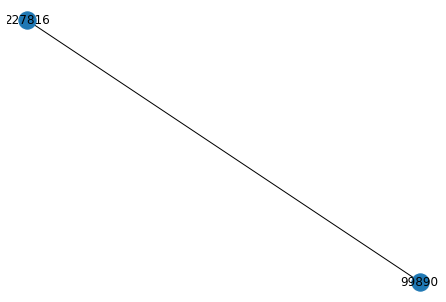

In [38]:
#PRINCIPAL COMPONENTE 1
#Top comoponent gr
Gccr = sorted(nx.connected_components(G_2), key=len, reverse=True)
Gr_top = G.subgraph(Gccr[0])

# graficamos red para nuestra grafica filtrada por peso
nx.draw(Gr_top, pos=nx.drawing.nx_agraph.graphviz_layout(Gr_top), with_labels=True)

In [35]:
a=list(Gr_top.nodes)
df_filtered = df[df['Criminales'].isin(a)]
df_filtered

,OffenderIdentifier,OffenderGender,CrimeIdentifier,CrimeType1,CrimeType2,CrimeType3,CrimeType4,Municipality,CrimeLocation,NumberYouthOffenders,NumberAdultOffenders,CrimeDate,CrimeYear,Crimen,Criminales
1236128,644159,M,339773,21401.0,NaN,NaN,NaN,66023,21.0,0,5,08/22/2008,2008,1134999,513247
1236129,644159,M,339838,21401.0,NaN,NaN,NaN,66023,21.0,0,5,09/01/2008,2008,1135000,513247
1236130,644159,M,340285,21203.0,3830.0,21409.0,NaN,66023,71.0,0,5,08/21/2008,2008,1135001,513247
1236131,644159,M,340080,21701.0,NaN,NaN,NaN,66023,10.0,1,2,10/10/2008,2008,1120455,513247
1236132,644159,M,339781,21401.0,NaN,NaN,NaN,66023,21.0,0,5,08/24/2008,2008,1135002,513247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265538,659803,M,339762,21203.0,21409.0,21702.0,NaN,66023,10.0,0,5,08/21/2008,2008,1135022,528865
1265539,659803,M,339835,21401.0,NaN,NaN,NaN,66023,21.0,0,5,09/02/2008,2008,1135023,528865
1265540,659803,M,339746,21401.0,NaN,NaN,NaN,66023,21.0,0,5,08/17/2008,2008,1135024,528865
1265541,659803,M,339717,21401.0,NaN,NaN,NaN,66023,5.0,0,5,08/12/2008,2008,1135025,528865


In [ ]:
# parece que son resultados no tan interesantes, 
#son parejas o tercias de personas muy reincidentes